# Comparative Analysis of Image classification models using Machine Learning and CNN

## Data Preparation

### Importing Libraries

In [23]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from skimage.io import imread
from skimage.color import rgb2gray
from skimage.transform import resize

#### Suppressing warnings

In [24]:
import warnings
warnings.filterwarnings("ignore")

### Defining paths to image dataset folder

In [25]:
# Define path to the data directory
data_dir = Path('chest_xray')

# Path to train directory
train_dir = data_dir / 'train'

# Path to validation directory
val_dir = data_dir / 'val'

# Path to test directory
test_dir = data_dir / 'test'

### Creating Training dataframe

In [26]:
# Get the path to the normal and pneumonia sub-directories
train_normal_cases_dir = train_dir / 'NORMAL'
train_pneumonia_cases_dir = train_dir / 'PNEUMONIA'

# Get the list of all the images
train_normal_cases = train_normal_cases_dir.glob('*.jpeg')
train_pneumonia_cases = train_pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in train_normal_cases:
    train_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in train_pneumonia_cases:
    train_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data = pd.DataFrame(train_data, columns=['image', 'label'],index=None)

# Shuffle the data 
# train_data = train_data.sample(frac=1., random_state=0).reset_index(drop=True)
train_data = train_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
train_data.head()

,image,label
0,chest_xray\train\PNEUMONIA\person547_bacteria_...,1
1,chest_xray\train\PNEUMONIA\person1090_virus_18...,1
2,chest_xray\train\PNEUMONIA\person282_virus_579...,1
3,chest_xray\train\PNEUMONIA\person504_bacteria_...,1
4,chest_xray\train\PNEUMONIA\person1016_bacteria...,1


### Creating Testing dataframe

In [27]:
# Get the path to the normal and pneumonia sub-directories
test_normal_cases_dir = test_dir / 'NORMAL'
test_pneumonia_cases_dir = test_dir / 'PNEUMONIA'

# Get the list of all the images
test_normal_cases = test_normal_cases_dir.glob('*.jpeg')
test_pneumonia_cases = test_pneumonia_cases_dir.glob('*.jpeg')

# An empty list. We will insert the data into this list in (img_path, label) format
test_data = []

# Go through all the normal cases. The label for these cases will be 0
for img in test_normal_cases:
    test_data.append((img,0))

# Go through all the pneumonia cases. The label for these cases will be 1
for img in test_pneumonia_cases:
    test_data.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
test_data = pd.DataFrame(test_data, columns=['image', 'label'],index=None)

# Shuffle the data 
# test_data = test_data.sample(frac=1., random_state=0).reset_index(drop=True)
test_data = test_data.sample(frac=1.).reset_index(drop=True)

# How the dataframe looks like?
test_data.head()

,image,label
0,chest_xray\test\PNEUMONIA\person143_bacteria_6...,1
1,chest_xray\test\PNEUMONIA\person83_bacteria_40...,1
2,chest_xray\test\PNEUMONIA\person101_bacteria_4...,1
3,chest_xray\test\PNEUMONIA\person124_bacteria_5...,1
4,chest_xray\test\NORMAL\NORMAL2-IM-0171-0001.jpeg,0


## Exploratory Data Analysis

### Displaying 5 Pneumonia and Normal case images each

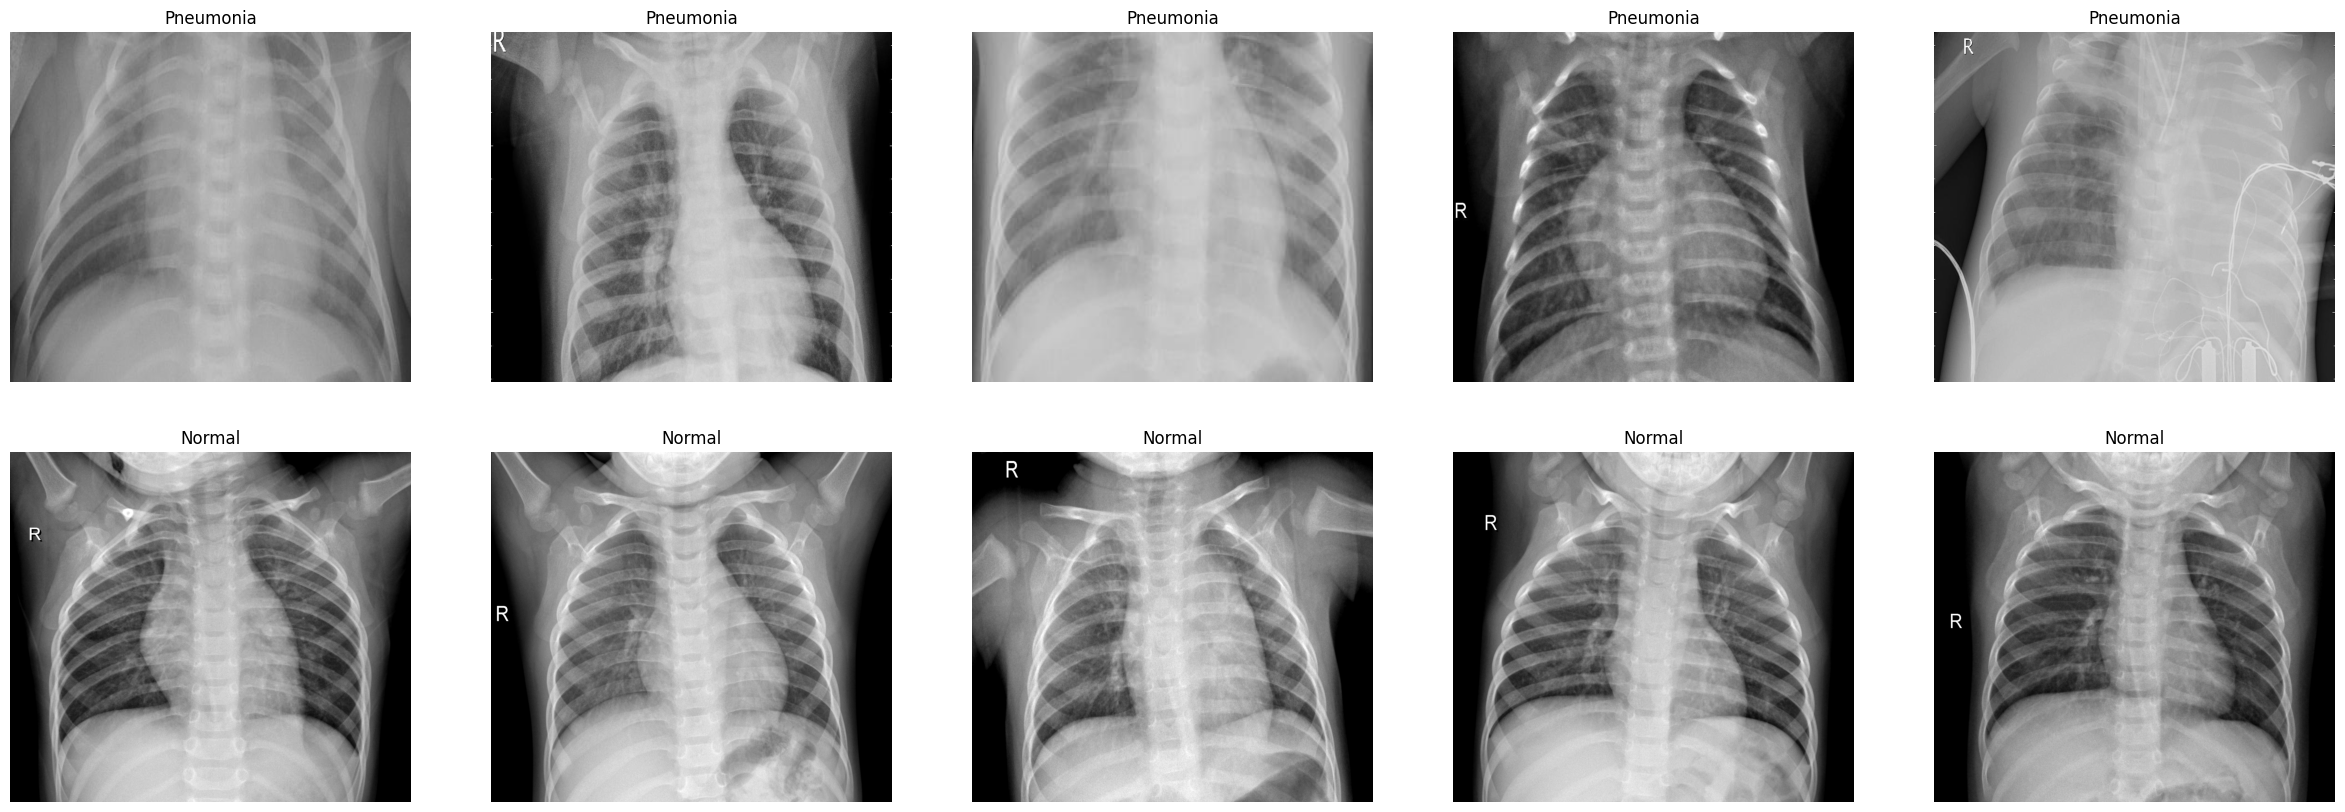

In [28]:
# Get few samples for both the classes
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

# Plot the data 
_, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
    else:
        ax[i//5, i%5].set_title("Normal")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

### Checking the Class distribution

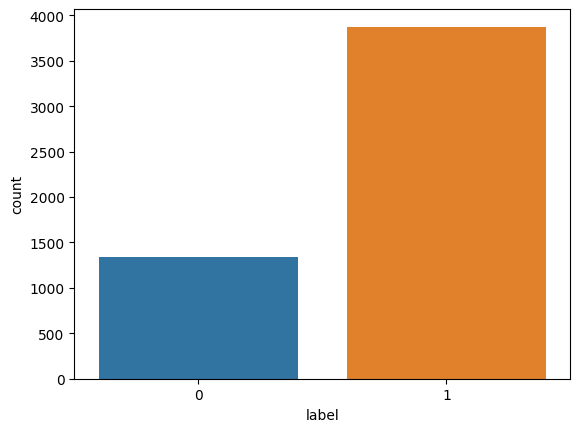

In [29]:
sns.countplot(data=train_data, x='label')
plt.show()

#### Inference
1. Our dataset is unbalanced. We have much lesser normal cases that pneumonia cases. 
2. We will calculate the number of normal cases and take the same number of normal and pneumonia cases

In [30]:
# Finding number of observations in test dataset
len(train_data[train_data['label']==0])

1341

#### Balancing Class distribution
We will take 1300 observations from both classes

In [31]:
train_data_balanced = []

for img in train_data[train_data['label']==1][:1300]['image']:
    train_data_balanced.append((img,1))

for img in train_data[train_data['label']==0][:1300]['image']:
    train_data_balanced.append((img,0))

# Get a pandas dataframe from the data we have in our list 
train_data_balanced = pd.DataFrame(train_data_balanced, columns=['image', 'label'],index=None)

# Shuffle the data 
train_data_balanced = train_data_balanced.sample(frac=1., random_state=0).reset_index(drop=True)

# How the dataframe looks like?
train_data_balanced.head()

,image,label
0,chest_xray\train\PNEUMONIA\person1507_bacteria...,1
1,chest_xray\train\NORMAL\NORMAL2-IM-1412-0001.jpeg,0
2,chest_xray\train\NORMAL\NORMAL2-IM-0690-0001.jpeg,0
3,chest_xray\train\PNEUMONIA\person1601_bacteria...,1
4,chest_xray\train\NORMAL\IM-0189-0001.jpeg,0


#### Visualizing distribution of balanced training dataset

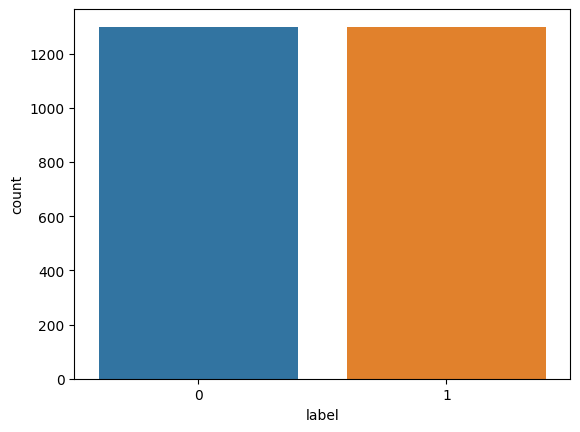

In [32]:
sns.countplot(data=train_data_balanced, x='label')
plt.show()

## Inferring useful columns

### Finding the size of each image

In [33]:
sizes = []
for imgPath in train_data_balanced['image']:
    img = imread(imgPath)
    size = img.shape
    sizes.append(size)

train_data_balanced['size'] = sizes
train_data_balanced

,image,label,size
0,chest_xray\train\PNEUMONIA\person1507_bacteria...,1,"(1064, 1552)"
1,chest_xray\train\NORMAL\NORMAL2-IM-1412-0001.jpeg,0,"(1216, 1784)"
2,chest_xray\train\NORMAL\NORMAL2-IM-0690-0001.jpeg,0,"(897, 1198)"
3,chest_xray\train\PNEUMONIA\person1601_bacteria...,1,"(840, 1256)"
4,chest_xray\train\NORMAL\IM-0189-0001.jpeg,0,"(1109, 1466)"
...,...,...,...
2595,chest_xray\train\PNEUMONIA\person1507_bacteria...,1,"(1352, 1776)"
2596,chest_xray\train\NORMAL\NORMAL2-IM-0448-0001.jpeg,0,"(1225, 1774)"
2597,chest_xray\train\PNEUMONIA\person331_bacteria_...,1,"(768, 1168)"
2598,chest_xray\train\PNEUMONIA\person1720_bacteria...,1,"(648, 1152)"


### Calculating the image size ratios and vector length of all images

In [34]:
ratios = []
lengths = []
for size in train_data_balanced['size']:
  length = size[1] * size[0]
  ratio = size[1] / size[0]
  lengths.append(length)
  ratios.append(ratio)

train_data_balanced['length'] = lengths
train_data_balanced['ratio'] = ratios
train_data_balanced

,image,label,size,length,ratio
0,chest_xray\train\PNEUMONIA\person1507_bacteria...,1,"(1064, 1552)",1651328,1.458647
1,chest_xray\train\NORMAL\NORMAL2-IM-1412-0001.jpeg,0,"(1216, 1784)",2169344,1.467105
2,chest_xray\train\NORMAL\NORMAL2-IM-0690-0001.jpeg,0,"(897, 1198)",1074606,1.335563
3,chest_xray\train\PNEUMONIA\person1601_bacteria...,1,"(840, 1256)",1055040,1.495238
4,chest_xray\train\NORMAL\IM-0189-0001.jpeg,0,"(1109, 1466)",1625794,1.321912
...,...,...,...,...,...
2595,chest_xray\train\PNEUMONIA\person1507_bacteria...,1,"(1352, 1776)",2401152,1.313609
2596,chest_xray\train\NORMAL\NORMAL2-IM-0448-0001.jpeg,0,"(1225, 1774)",2173150,1.448163
2597,chest_xray\train\PNEUMONIA\person331_bacteria_...,1,"(768, 1168)",897024,1.520833
2598,chest_xray\train\PNEUMONIA\person1720_bacteria...,1,"(648, 1152)",746496,1.777778


### Exploring the balanced dataset with additional inferred columns

In [35]:
train_data_balanced.describe()

,label,length,ratio
count,2600.000000,2.600000e+03,2600.000000
mean,0.500000,1.720591e+06,1.372189
std,0.500096,1.060607e+06,0.245886
min,0.000000,5.887200e+04,0.877220
25%,0.000000,8.908800e+05,1.204066
50%,0.500000,1.557337e+06,1.326528
75%,1.000000,2.255592e+06,1.500000
max,1.000000,7.532028e+06,3.378788


#### Visualizing the vector lengths of all images

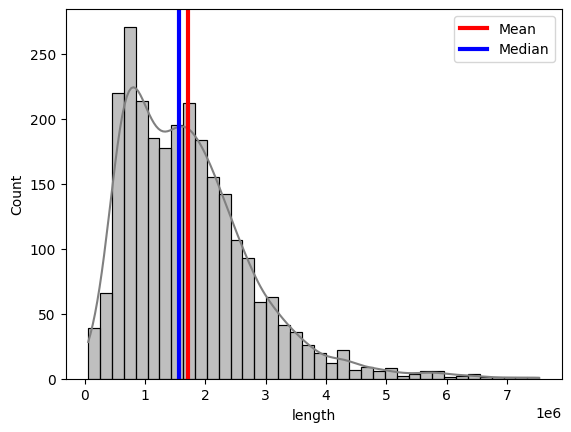

In [36]:
sns.histplot(data=train_data_balanced, x='length', color='gray', kde=True)
plt.axvline(train_data_balanced['length'].mean(), color='red', lw=3, label="Mean")
plt.axvline(train_data_balanced['length'].median(), color='blue', lw=3, label="Median")
plt.legend()
plt.show()

We will resize all images to the mean size

In [37]:
length = train_data_balanced['length'].min()
print(length)

# We will rescale all images into x*x images
x = int(np.sqrt(length))
x

58872


242

## Machine Learning Models

##### Function to create the image dataset to be used in Machine Learning model

In [38]:
def makeDataset(data):
    dataset = ""
    for location in data:
        # reading the image from location
        img = imread(location)
        
        # turning rgb images to grayscale
        if len(img.shape) == 3:
            img = rgb2gray(img)

        # resizing to our desired size and scaling it to 255
        img = resize(img, (x, x), anti_aliasing=True) * 255

        # converting to uint8 for saving memory
        img = img.astype(np.uint8)

        # converting to vector
        img = img.reshape(-1)

        # initiating dataset or vstacking onto dataset
        if type(dataset) == str:
            dataset = img
        else:
            dataset = np.vstack([dataset, img])

    # returning dataset
    return dataset

##### Function to create the training and testing datasets

In [39]:
def train_test_split(train, test, train_size=500, test_proportion=0.2):
    test_size = int(test_proportion * train_size)

    X_train = makeDataset(train['image'][:train_size])
    y_train = train['label'][:train_size]
    X_test = makeDataset(test['image'][:test_size])
    y_test = test['label'][:test_size]
    
    return (X_train, X_test, y_train, y_test)

##### Function to perform LDA on the image dataset

In [40]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

def doLDA(X_train, y_train, X_test):
    lda = LDA()
    lda.fit(X_train, y_train)
    X_train_lda = lda.transform(X_train)
    X_test_lda = lda.transform(X_test)
    
    return(X_train_lda, X_test_lda)

##### Dictionary that holds the model objects for each type of ML Classifier

In [41]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Support Vector Machine": SVC(gamma='auto'),
    "Gaussian Naive Bayes": GaussianNB(),
    "K Nearest Neighbours": KNeighborsClassifier(n_neighbors=3),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(max_depth=2)
}

### Comparing different ML models

In [42]:
from sklearn.metrics import accuracy_score

# Dictionary to hold the accuracy metrics
metrics = {
    "Classifier": [],
    "Test Proportion": [],
    "Accuracy (without LDA)": [],
    "Accuracy (with LDA)": []
}

# Looping through different test proportions
for test_proportion in [0.1, 0.15, 0.2, 0.25, 0.3, 0.35]:

    # Looping through different ML models
    for name, clf in classifiers.items():    
        metrics['Classifier'].append(name)
        metrics["Test Proportion"].append(test_proportion)
        
        # Creating train and test dataset and performing LDA
        X_train, X_test, y_train, y_test = train_test_split(train_data_balanced, test_data, test_proportion=test_proportion)
        X_train_lda, X_test_lda = doLDA(X_train, y_train, X_test)

        # Fitting model to LDA dataset
        clf.fit(X_train_lda, y_train)
        y_pred = clf.predict(X_test_lda)
        acc = accuracy_score(y_test, y_pred)
        metrics['Accuracy (with LDA)'].append(np.round(acc, decimals=3))

        # Fitting model to non-LDA dataset
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        metrics['Accuracy (without LDA)'].append(np.round(acc, decimals=3))
        
    # Printing confirmation after each test proportion
    print(f"Done for test proportion {test_proportion}")

# Converting metrics dictionary into dataframe and displaying
metrics = pd.DataFrame(metrics)
metrics

Done for test proportion 0.1
Done for test proportion 0.15
Done for test proportion 0.2
Done for test proportion 0.25
Done for test proportion 0.3
Done for test proportion 0.35


,Classifier,Test Proportion,Accuracy (without LDA),Accuracy (with LDA)
0,Logistic Regression,0.10,0.900,0.900
1,Support Vector Machine,0.10,0.760,0.900
2,Gaussian Naive Bayes,0.10,0.720,0.900
3,K Nearest Neighbours,0.10,0.840,0.900
4,Decision Tree,0.10,0.780,0.840
5,Random Forest,0.10,0.660,0.900
6,Logistic Regression,0.15,0.867,0.867
7,Support Vector Machine,0.15,0.747,0.867
8,Gaussian Naive Bayes,0.15,0.760,0.867
9,K Nearest Neighbours,0.15,0.853,0.867


#### Exporting ML accuracy metrics to external csv file

In [43]:
metrics.to_csv("Machine_Learning_Metrics.csv", index=False)

## CNN

### Importing CNN libraries

In [44]:
from keras import Sequential
from keras.layers import Conv2D,MaxPooling2D,Dropout,Flatten,Dense,BatchNormalization
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator

### Resizing images and creating batches

In [45]:
train_datagen = ImageDataGenerator(rescale=1/255,shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)
training_set = train_datagen.flow_from_directory(
        directory = data_dir / 'train',
        target_size=(64 , 64),
        batch_size=32,
        class_mode='binary')
test_datagen = ImageDataGenerator(rescale=1./255)
test_set = test_datagen.flow_from_directory(
        directory = data_dir / 'test',
        target_size=(64 , 64),
        batch_size=32,
        class_mode='binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Creating validation data

In [46]:
validation = ImageDataGenerator(rescale=1./255)
vall = test_datagen.flow_from_directory(
        directory =data_dir / 'val',
        target_size=(64 , 64),
        batch_size=32,
        class_mode='binary')

Found 16 images belonging to 2 classes.


### Creating Convolution model with 3 layers

In [47]:
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


#### Programming early stop

In [51]:
early_stop = EarlyStopping(monitor='val_loss',patience=4, mode='min')

### Performing CNN

In [52]:
results = model.fit(training_set,epochs=30,validation_data = test_set, callbacks=early_stop)

Epoch 1/30
163/163 [==============================] - 59s 361ms/step - loss: 0.1087 - accuracy: 0.9578 - val_loss: 0.4125 - val_accuracy: 0.8670
Epoch 2/30
163/163 [==============================] - 59s 362ms/step - loss: 0.1039 - accuracy: 0.9628 - val_loss: 0.3015 - val_accuracy: 0.8926
Epoch 3/30
163/163 [==============================] - 59s 362ms/step - loss: 0.1015 - accuracy: 0.9647 - val_loss: 0.3261 - val_accuracy: 0.8894
Epoch 4/30
163/163 [==============================] - 59s 361ms/step - loss: 0.0968 - accuracy: 0.9661 - val_loss: 0.3435 - val_accuracy: 0.9054
Epoch 5/30
163/163 [==============================] - 99s 612ms/step - loss: 0.1013 - accuracy: 0.9618 - val_loss: 0.2285 - val_accuracy: 0.9231
Epoch 6/30
163/163 [==============================] - 142s 874ms/step - loss: 0.0997 - accuracy: 0.9638 - val_loss: 0.2212 - val_accuracy: 0.9327
Epoch 7/30
163/163 [==============================] - 131s 802ms/step - loss: 0.0924 - accuracy: 0.9653 - val_loss: 0.3621 - val_

### Visualizing CNN results

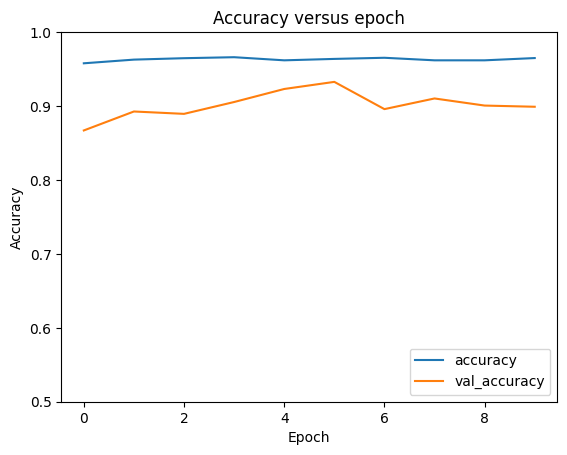

In [53]:
plt.title("Accuracy versus epoch")
plt.plot(results.history['accuracy'], label='accuracy')
plt.plot(results.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')